# **Предсказание наличие спама в сообщениях электронной почты на основе содержащегося в них текста с помощью фреймворка PyTorch**

## **1. Импорт библиотек**

In [1]:
# !pip install sentence_transformers
# !pip install nltk

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import nltk

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from transformers import BertModel, BertTokenizer
from transformers import GPT2Tokenizer, GPT2Model
from sentence_transformers import SentenceTransformer

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import accuracy_score, f1_score

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

C:\Users\Alex\anaconda3\envs\bert\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Alex\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Alex\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Alex\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Alex\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

## **2. Загрузка датасета**

In [3]:
df = pd.read_csv('data/email_text.csv', nrows=1000)
df.shape

(1000, 2)

In [4]:
df.head()

,label,text
0,0,the mailing list i queried about a few weeks a...
1,1,luxury watches buy your own rolex for only esc...
2,1,academic qualifications available from prestig...
3,0,greetings all this is to verify your subscript...
4,1,try chauncey may conferred the luscious not co...


In [5]:
df.label.value_counts()

label
0    652
1    348
Name: count, dtype: int64

Выборка не сбалансирована

## **3. Предобработка данных**

In [6]:
df.isna().sum()

label    0
text     0
dtype: int64

In [7]:
def text_cleaner(text):
    # Преобразование текста в нижний регистр
    text = text.lower()

    # Удаление лишних пробелов
    text = re.sub(r'\s+', ' ', text)

    # Преобразование сокращений
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"can't", "cannot", text)
    text = re.sub(r"n't", " not", text)
    text = re.sub(r"'ve", " have", text)
    text = re.sub(r"'ll", " will", text)
    text = re.sub(r"'d", " would", text)
    text = re.sub(r"'re", " are", text)
    text = re.sub(r"'s", " is", text)
    text = re.sub(r"'m", " am", text)

    # Удаление знаков препинания
    text = re.sub(r'[^\w\s]', '', text)

    # Удаление стоп-слов
    stop_words = set(stopwords.words('english'))
    tokens = word_tokenize(text)
    filtered_text = [word for word in tokens if word.lower() not in stop_words]

    # Лемматизация слов
    lemmatizer = WordNetLemmatizer()
    lemmatized_text = [lemmatizer.lemmatize(word) for word in filtered_text]

    # Объединение лемматизированных слов обратно в текст
    cleaned_text = ' '.join(lemmatized_text)

    return cleaned_text

In [8]:
df['cleaner_text'] = df['text'].apply(lambda x: text_cleaner(x))

In [9]:
df.head()

,label,text,cleaner_text
0,0,the mailing list i queried about a few weeks a...,mailing list queried week ago running also set...
1,1,luxury watches buy your own rolex for only esc...,luxury watch buy rolex escapenumber rolex cart...
2,1,academic qualifications available from prestig...,academic qualification available prestigious n...
3,0,greetings all this is to verify your subscript...,greeting verify subscription planescapenumber ...
4,1,try chauncey may conferred the luscious not co...,try chauncey may conferred luscious continued ...


## **4. Modeling**

### **4.1. Получение эмбеддингов с помощью BERT**

In [10]:
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)

In [11]:
model = SentenceTransformer(model_name)

No sentence-transformers model found with name bert-base-uncased. Creating a new one with mean pooling.


In [12]:
embeddings = model.encode(df['cleaner_text'].tolist())
embeddings.shape

(1000, 768)

#### **4.1.1. Обучение модели**

In [13]:
X_train, X_test, y_train, y_test = train_test_split(embeddings, df.label, test_size=0.2, random_state=42)

In [14]:
# Преобразование данных в тензоры PyTorch
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

# Создание DataLoader для обучающего и тестового наборов данных
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

In [15]:
# Определение модели
class SpamClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout=0.9):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = self.relu(self.fc1(x))
        out = self.dropout(out)
        out = self.fc2(out)
        out = self.sigmoid(out)
        return out

In [16]:
input_size = embeddings.shape[1]
hidden_size = 256
output_size = 1
num_epochs = 20

In [17]:
model = SpamClassifier(input_size, hidden_size, output_size)

In [18]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters())

In [19]:
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

# Обучение модели
for epoch in range(1, num_epochs+1):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for inputs, labels in train_loader:           
        outputs = model(inputs)
        loss = criterion(outputs, labels.unsqueeze(1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        # Вычисление точности на обучающей выборке
        total_train += labels.size(0)
        correct_train += sum(torch.tensor([1. if outputs.data[i] >= 0.5 else .0 for i in range(len(outputs))]) == labels)
        
    # Сохранение значений потерь и точности на обучающей выборке
    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(correct_train / total_train)
    
    # Оценка модели на тестовой выборке
    model.eval()
    test_loss = 0.0
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels.unsqueeze(1))
            test_loss += loss.item()

            # Вычисление точности на тестовой выборке
            total_test += labels.size(0)
            correct_test += sum(torch.tensor([1. if outputs.data[i] >= 0.5 else .0 for i in range(len(outputs))]) == labels)
            

    # Сохранение значений потерь и точности на тестовой выборке
    test_losses.append(test_loss / len(test_loader))
    test_accuracies.append(correct_test / total_test)

    print(f"Epoch {epoch}, Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}, Test Accuracy: {test_accuracies[-1]:.4f}")

Epoch 1, Train Loss: 0.6072, Train Accuracy: 0.6538, Test Loss: 0.4505, Test Accuracy: 0.8150
Epoch 2, Train Loss: 0.5068, Train Accuracy: 0.7513, Test Loss: 0.3620, Test Accuracy: 0.9100
Epoch 3, Train Loss: 0.4197, Train Accuracy: 0.8100, Test Loss: 0.2935, Test Accuracy: 0.9100
Epoch 4, Train Loss: 0.3804, Train Accuracy: 0.8413, Test Loss: 0.2548, Test Accuracy: 0.9200
Epoch 5, Train Loss: 0.3492, Train Accuracy: 0.8550, Test Loss: 0.2339, Test Accuracy: 0.9350
Epoch 6, Train Loss: 0.2998, Train Accuracy: 0.8737, Test Loss: 0.2061, Test Accuracy: 0.9500
Epoch 7, Train Loss: 0.2728, Train Accuracy: 0.9075, Test Loss: 0.2081, Test Accuracy: 0.9450
Epoch 8, Train Loss: 0.2535, Train Accuracy: 0.8950, Test Loss: 0.1869, Test Accuracy: 0.9600
Epoch 9, Train Loss: 0.2451, Train Accuracy: 0.9125, Test Loss: 0.1734, Test Accuracy: 0.9750
Epoch 10, Train Loss: 0.2115, Train Accuracy: 0.9225, Test Loss: 0.1725, Test Accuracy: 0.9650
Epoch 11, Train Loss: 0.2192, Train Accuracy: 0.9125, Test 

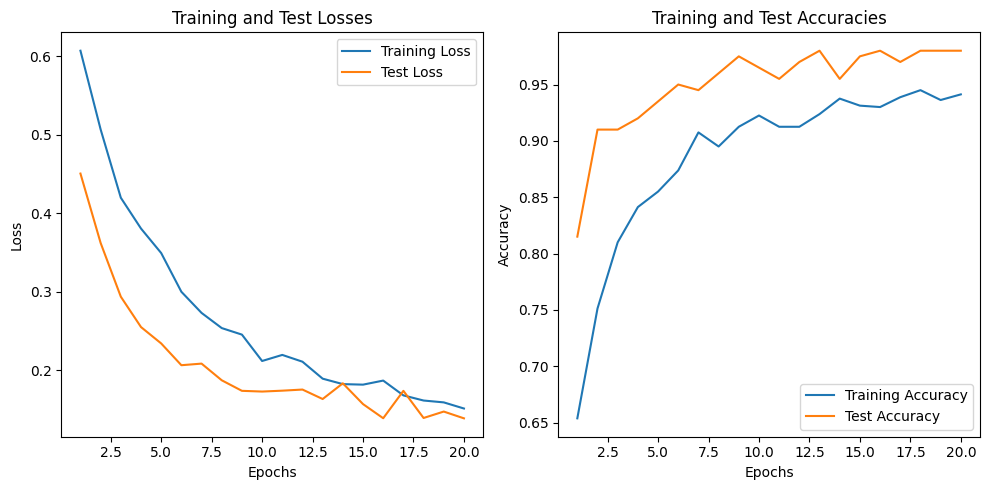

In [20]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs+1), test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Test Losses')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs+1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracies')
plt.legend()

plt.tight_layout()
plt.show()

#### **4.1.2. Метрики модели с эмбеддингами BERT**

In [21]:
probabilities = model(X_test_tensor)
predictions = probabilities.detach().numpy()

threshold = 0.5
predicted_labels = (predictions > threshold).astype(int)

# Вычисляем метрики
f1_weighted = f1_score(y_test_tensor, predicted_labels.squeeze(1), average='weighted')
accuracy = accuracy_score(y_test_tensor, predicted_labels.squeeze(1))

print(f'F1-score: {f1_weighted:.4f}')
print(f'Accuracy: {accuracy}')

F1-score: 0.9799
Accuracy: 0.98


### **4.2. Получение эмбеддингов с помощью GPT-2**

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [23]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token
model = GPT2Model.from_pretrained('gpt2')

In [24]:
model.to(device)

GPT2Model(
  (wte): Embedding(50257, 768)
  (wpe): Embedding(1024, 768)
  (drop): Dropout(p=0.1, inplace=False)
  (h): ModuleList(
    (0-11): 12 x GPT2Block(
      (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (attn): GPT2SdpaAttention(
        (c_attn): Conv1D(nf=2304, nx=768)
        (c_proj): Conv1D(nf=768, nx=768)
        (attn_dropout): Dropout(p=0.1, inplace=False)
        (resid_dropout): Dropout(p=0.1, inplace=False)
      )
      (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (mlp): GPT2MLP(
        (c_fc): Conv1D(nf=3072, nx=768)
        (c_proj): Conv1D(nf=768, nx=3072)
        (act): NewGELUActivation()
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
)

In [25]:
encoded_captions = tokenizer(
    df['cleaner_text'].tolist(),
    return_tensors='pt',
    padding=True,
    truncation=True)

In [26]:
encoded_captions = {key: value.to(device) for key, value in encoded_captions.items()}
input_ids = encoded_captions['input_ids']
batch_size = 4

In [27]:
all_sentence_embeddings = []

for i in range(0, len(encoded_captions['input_ids']), batch_size):
    batch_input_ids = encoded_captions['input_ids'][i:i+batch_size].to(device)
    batch_attention_mask = encoded_captions['attention_mask'][i:i+batch_size].to(device)

    with torch.no_grad():
        batch_outputs = model(batch_input_ids)

    word_embeddings = batch_outputs.last_hidden_state

    masked_word_embeddings = word_embeddings * batch_attention_mask.unsqueeze(-1).float()

    sentence_embeddings = masked_word_embeddings.sum(dim=1)

    sentence_embeddings /= batch_attention_mask.sum(dim=1, keepdim=True).float()

    all_sentence_embeddings.append(sentence_embeddings)

all_sentence_embeddings = torch.cat(all_sentence_embeddings, dim=0)

In [28]:
all_sentence_embeddings

tensor([[-0.0397, -0.1098, -0.3414,  ..., -0.2921,  0.1893,  0.3437],
        [ 0.1577, -0.1613, -0.2698,  ..., -0.0442,  0.1162,  0.2002],
        [ 0.1049,  0.0737, -0.5971,  ...,  0.2132,  0.3318,  0.0623],
        ...,
        [ 0.0898, -0.2799, -0.5587,  ...,  0.0197,  0.2609, -0.1169],
        [ 0.0719, -0.2068, -0.6526,  ...,  0.0997,  0.1555,  0.0533],
        [-0.0061, -0.2416, -0.5308,  ...,  0.0801,  0.2188,  0.0515]])

#### **4.2.1. Обучение модели**

In [29]:
X_train, X_test, y_train, y_test = train_test_split(all_sentence_embeddings, df.label, test_size=0.2, random_state=42)
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

# Создание DataLoader для обучающего и тестового наборов данных
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

C:\Users\Alex\AppData\Local\Temp\ipykernel_7284\4160157047.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
C:\Users\Alex\AppData\Local\Temp\ipykernel_7284\4160157047.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test_tensor = torch.tensor(X_test, dtype=torch.float32)


In [30]:
input_size = sentence_embeddings.shape[1]
hidden_size = 256
output_size = 1
num_epochs = 20

In [31]:
model_gpt = SpamClassifier(input_size, hidden_size, output_size)
model_gpt = model_gpt.to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model_gpt.parameters())

In [32]:
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

# Обучение модели
for epoch in range(1, num_epochs+1):
    model_gpt.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for inputs, labels in train_loader:
        inputs = inputs.to(device)  
        labels = labels.to(device)  
        outputs = model_gpt(inputs)
        loss = criterion(outputs, labels.unsqueeze(1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        total_train += labels.size(0)
        correct_train += sum(torch.tensor([1. if outputs.data[i] >= 0.5 else .0 for i in range(len(outputs))]) == labels)

    
    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(correct_train / total_train)

    model_gpt.eval()
    test_loss = 0.0
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device) 
            labels = labels.to(device)  
            outputs = model_gpt(inputs)
            loss = criterion(outputs, labels.unsqueeze(1))
            test_loss += loss.item()

            total_test += labels.size(0)
            correct_test += sum(torch.tensor([1. if outputs.data[i] >= 0.5 else .0 for i in range(len(outputs))]) == labels)

    test_losses.append(test_loss / len(test_loader))
    test_accuracies.append(correct_test / total_test)

    print(f"Epoch {epoch}, Train Loss: {train_losses[-1]}, Train Accuracy: {train_accuracies[-1]}, Test Loss: {test_losses[-1]}, Test Accuracy: {test_accuracies[-1]}")

Epoch 1, Train Loss: 1.642452347278595, Train Accuracy: 0.5375000238418579, Test Loss: 0.5657816444124494, Test Accuracy: 0.6949999928474426
Epoch 2, Train Loss: 0.7787032532691955, Train Accuracy: 0.6324999928474426, Test Loss: 0.48123781595911297, Test Accuracy: 0.8299999833106995
Epoch 3, Train Loss: 0.5639351832866669, Train Accuracy: 0.6887500286102295, Test Loss: 0.4325434948716845, Test Accuracy: 0.8450000286102295
Epoch 4, Train Loss: 0.5243764781951904, Train Accuracy: 0.762499988079071, Test Loss: 0.37951078585215975, Test Accuracy: 0.9200000166893005
Epoch 5, Train Loss: 0.5098331725597381, Train Accuracy: 0.7599999904632568, Test Loss: 0.34635165333747864, Test Accuracy: 0.8999999761581421
Epoch 6, Train Loss: 0.45478919267654416, Train Accuracy: 0.7799999713897705, Test Loss: 0.30148289459092276, Test Accuracy: 0.9449999928474426
Epoch 7, Train Loss: 0.43748314380645753, Train Accuracy: 0.8050000071525574, Test Loss: 0.26282788600240437, Test Accuracy: 0.9399999976158142
E

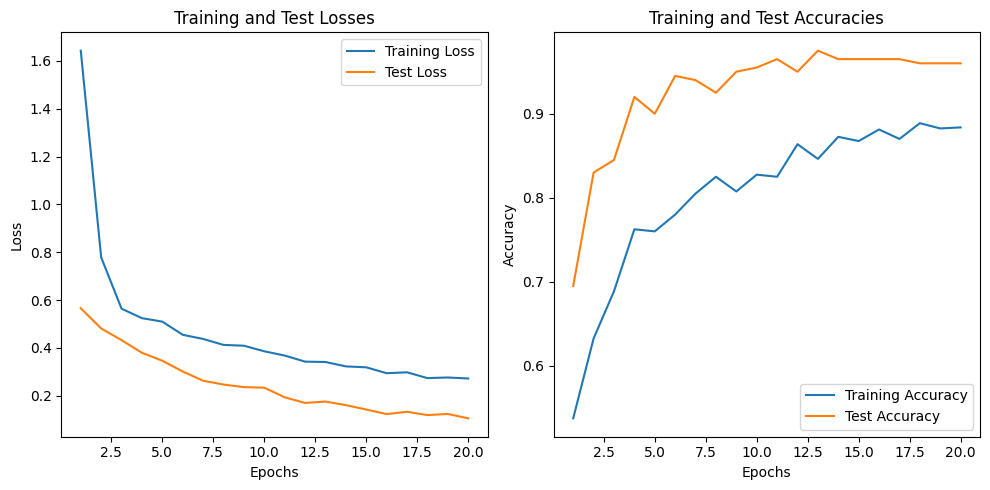

In [33]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs+1), test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Test Losses')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs+1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracies')
plt.legend()

plt.tight_layout()
plt.show()

#### **4.2.2. Метрики модели с эмбеддингами GPT-2**

In [34]:
probabilities = model_gpt(X_test_tensor)
predictions = probabilities.detach().numpy()

threshold = 0.5
predicted_labels = (predictions > threshold).astype(int)

# Вычисляем метрики
f1_weighted = f1_score(y_test_tensor, predicted_labels.squeeze(1), average='weighted')
accuracy = accuracy_score(y_test_tensor, predicted_labels.squeeze(1))

print(f'F1-score: {f1_weighted:.4f}')
print(f'Accuracy: {accuracy}')

F1-score: 0.9596
Accuracy: 0.96
